(1600, 1200, 3)

Quadrilateral detected!


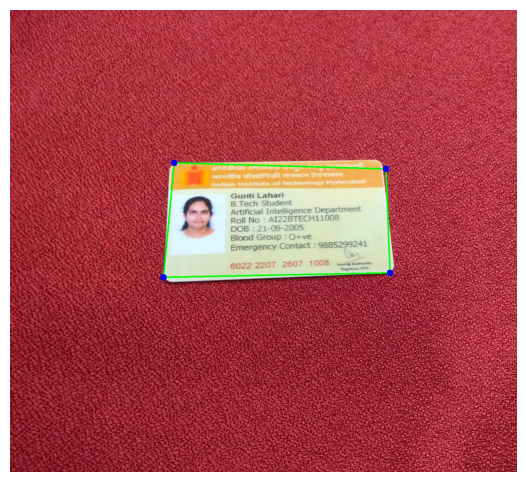

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def reorder_points(pts):
    """Reorders points to [top-left, top-right, bottom-right, bottom-left]."""
    pts = pts.reshape((4, 2))
    new_pts = np.zeros((4, 2), dtype=np.float32)
    add = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    new_pts[0] = pts[np.argmin(add)]      # Top-left
    new_pts[1] = pts[np.argmin(diff)]    # Top-right
    new_pts[2] = pts[np.argmax(add)]     # Bottom-right
    new_pts[3] = pts[np.argmax(diff)]    # Bottom-left
    return new_pts

def detect_quadrilateral(image_path):
    # Read and preprocess the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(gray, (5, 5), 1)

    # Apply adaptive thresholding for better edge detection
    _, thresh = cv2.threshold(imgBlur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(thresh, 50, 150)

    # Morphological transformations to close gaps
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.erode(edges, kernel, iterations=1)

    # Find contours
    cntrs, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = 5000  # Minimum contour area to filter small noise
    filtered_cntrs = [c for c in cntrs if cv2.contourArea(c) > min_area]

    if filtered_cntrs:
        # Find the largest contour
        cnt_max = max(filtered_cntrs, key=cv2.contourArea)

        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(cnt_max, True)
        approx = cv2.approxPolyDP(cnt_max, epsilon, True)

        if len(approx) == 4:
            print("Quadrilateral detected!")
            # Reorder points and draw the contour
            approx_reordered = reorder_points(approx)
            cv2.drawContours(img, [np.int32(approx_reordered)], -1, (0, 255, 0), 3)
        elif len(approx) > 4:
            print(f"Detected {len(approx)} points. Forcing reduction to 4 points.")

            # Take the convex hull and simplify it to 4 points
            hull = cv2.convexHull(cnt_max)
            epsilon = 0.02 * cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, epsilon, True)

            if len(approx) > 4:
                # Force reduction to the 4 largest points
                approx = sorted(approx, key=lambda x: cv2.contourArea(cv2.convexHull(x)))[:4]

            approx_reordered = reorder_points(np.array(approx))
            cv2.drawContours(img, [np.int32(approx_reordered)], -1, (0, 0, 255), 3)
        else:
            print(f"Only {len(approx)} points detected. Unable to form a quadrilateral.")
            cv2.drawContours(img, [approx], -1, (255, 0, 0), 3)

        # Mark corner points for better visualization
        for point in approx:
            x, y = point.ravel()
            cv2.circle(img, (x, y), 10, (255, 0, 0), -1)

        # Display result
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("No valid contours detected. Adjust preprocessing or thresholds.")

# Run the function
image_path = '/content/3.jpeg'
detect_quadrilateral(image_path)


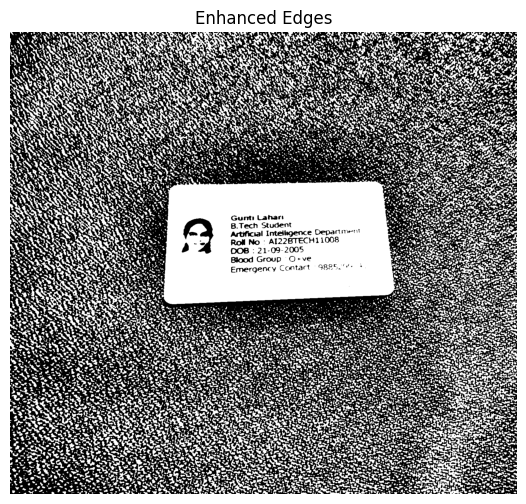

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhance_contrast(image):
    """Enhance contrast using CLAHE."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel back with a and b channels
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    return enhanced_img

def preprocess_with_contrast(image):
    """Preprocess the image by enhancing contrast and applying thresholding."""
    # Enhance contrast
    enhanced_img = enhance_contrast(image)

    # Convert to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    imgBlur = cv2.GaussianBlur(gray, (5, 5), 1)

    # Adaptive thresholding for better edge detection
    _, thresh = cv2.threshold(imgBlur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresh

# Load and preprocess the image
image_path = '/content/3.jpeg'
img = cv2.imread(image_path)
enhanced_edges = preprocess_with_contrast(img)

# Visualize the enhanced edges
plt.figure(figsize=(10, 6))
plt.imshow(enhanced_edges, cmap='gray')
plt.axis('off')
plt.title("Enhanced Edges")
plt.show()


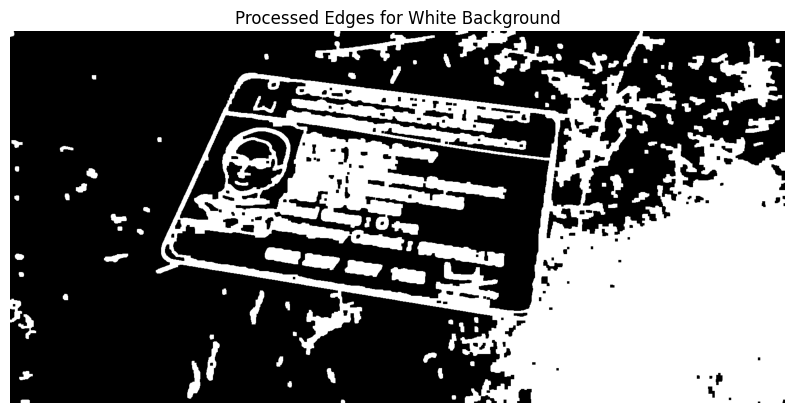

Detected 6 points, not a quadrilateral.


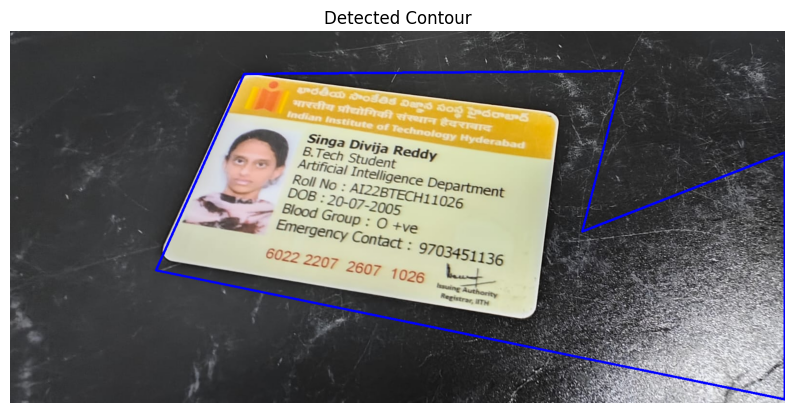

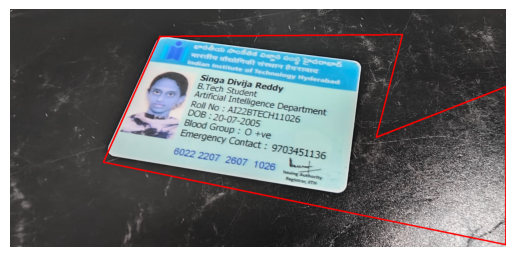

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_white_background(image):
    """Mask white background to isolate the ID card."""
    # Convert to HSV (Hue, Saturation, Value) color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define range for white color in HSV
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 25, 255])

    # Create a mask to detect white regions
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Invert the mask to keep the card
    mask_inv = cv2.bitwise_not(mask)

    # Apply the mask to the original image
    result = cv2.bitwise_and(image, image, mask=mask_inv)

    return result

def preprocess_white_background(image):
    # Step 1: Mask the white background
    masked_image = mask_white_background(image)

    # Step 2: Convert masked image to grayscale
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # Step 3: Enhance contrast (invert + blur)
    inverted = cv2.bitwise_not(gray)
    blurred = cv2.GaussianBlur(inverted, (5, 5), 1)

    # Step 4: Detect edges
    edges = cv2.Canny(blurred, 30, 100)

    # Step 5: Morphological operations to clean edges
    kernel = np.ones((5, 5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.erode(edges, kernel, iterations=1)

    return edges

# Load and preprocess the image
image_path = '/content/1.jpeg'
img = cv2.imread(image_path)
edges = preprocess_white_background(img)

# Visualize the edges
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title("Processed Edges for White Background")
plt.show()

# Find contours based on preprocessed edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 5000  # Minimum contour area
contours = [c for c in contours if cv2.contourArea(c) > min_area]

if contours:
    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate contour to a polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Ensure we have a quadrilateral
    if len(approx) == 4:
        print("Detected quadrilateral!")
        cv2.drawContours(img, [approx], -1, (0, 255, 0), 3)
    else:
        print(f"Detected {len(approx)} points, not a quadrilateral.")
        cv2.drawContours(img, [approx], -1, (255, 0, 0), 3)

    # Display final result
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Contour")
    plt.show()
    gray_image = grayscale(img)
    # Display the image using Matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No valid contours detected.")


